In [24]:
import sys
sys.path.append("/home/amigos/seigyo/analy/shiotani/git/analy_n2data/")
import necstdb
import math
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import n2analy
import xarray as xr
from datetime import datetime
import numpy as np
from scipy.optimize import curve_fit
import astropy
from astropy import coordinates as co
from astropy.time import Time
from astropy.coordinates import SkyCoord
from datetime import datetime

In [2]:
path = '/mnt/usbdisk9/data/observation/otf_planet2018/n20200320150852_12CO_2-1_otfplanet_jupiter'

In [3]:
xFFTS_Data_topics = [
    
    'ac240_spectra_data_1',
    'ac240_spectra_data_2',
]

In [4]:
def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table('ac240_spectra_data_1').read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.interp_like(spec_array)
    reindexed_encoder_el_array = el_array.interp_like(spec_array)
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'scan_num':('t', np.array(reindexed_obsmode_array['scan_num'])),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

def get_lb(raw_array, time, location):
    AltAzcoordiantes = astropy.coordinates.SkyCoord(
        
        az=raw_array['azlist'], 
        alt=raw_array['ellist'], 
        frame='altaz', 
        obstime=time,
        location=location, 
        unit='deg')
    
    l_list = AltAzcoordiantes.transform_to(Galactic).l
    b_list = AltAzcoordiantes.transform_to(Galactic).b
    return l_list, b_list

def make_data_array(raw_array, l_list, b_list, filename='hogehoge', save=False):
    data_array = xr.DataArray(
        np.array(raw_array), 
        dims=['t', 'spectral_data'],
        coords={'t':raw_array['t'],
               'obsmode':('t',np.array(raw_array['obsmode'])),
               'scan_num':('t', np.array(raw_array['scan_num'])),
               'l_list':('t', l_list),
               'b_list':('t', b_list)}
    )
    
    if save == True:
        data_array.to_netcdf(f"/mnt/usbdisk10/analy_n2data/OTF_netcdf/{filename}.cdf")
    return data_array

In [5]:
spec_array, obsmode_array, az_array, el_array = get_array(path, xFFTS_Data_topics[0])
raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)

In [6]:
ON_OL = raw_array['obsmode'] == b'ON        '
ON = raw_array[ON_OL]
ON_TP = np.sum(ON,axis=1)

In [7]:
scan_num_list = np.unique(np.array(ON_TP['scan_num']))
ON_TP_scan_num_list = [ON_TP[ON_TP['scan_num'] == scan_num] for scan_num in scan_num_list]

In [8]:
az_list = [ON_TP_scan_num['azlist'] for ON_TP_scan_num in ON_TP_scan_num_list]

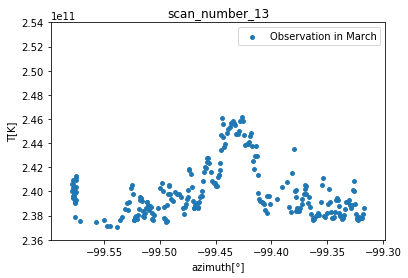

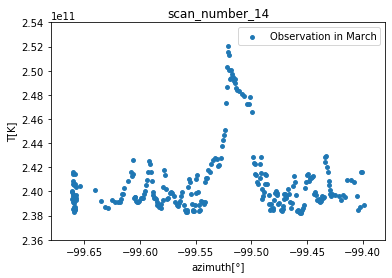

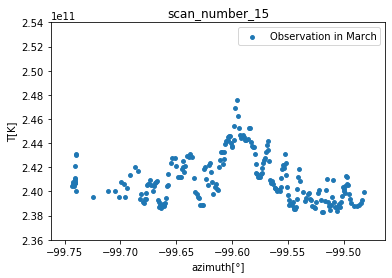

In [10]:
for i in range(3):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(az_list[i+13],ON_TP_scan_num_list[i+13], s=15, label='Observation in March')
    ax.set_title('scan_number_' + f'{i+13}')
    ax.set_xlabel('azimuth[°]')
    ax.set_ylabel('T[K]')
    ax.set_ylim(2.36e11,2.54e11)
    ax.legend()
    #fig.savefig(f'/home/amigos/seigyo/analy/notebook_2020/Nishioka/per_az_2_1_ncw/az_T*_scan_number{i+13}.png')

In [11]:
time_unix_list = np.array(raw_array['t'])

In [12]:
time_gen_list = [datetime.fromtimestamp(time_unix) for time_unix in time_unix_list]

In [17]:
jupiter_radec_list = co.get_body('Jupiter', Time(time_gen_list))

In [18]:
jupiter_radec_list

<SkyCoord (GCRS: obstime=[datetime.datetime(2020, 3, 21, 0, 8, 52, 982919)
 datetime.datetime(2020, 3, 21, 0, 8, 53, 190781)
 datetime.datetime(2020, 3, 21, 0, 8, 53, 406458) ...
 datetime.datetime(2020, 3, 21, 0, 50, 33, 667115)
 datetime.datetime(2020, 3, 21, 0, 50, 33, 898034)
 datetime.datetime(2020, 3, 21, 0, 50, 33, 930762)], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    [(294.42919209, -21.58231895, 5.48942604),
     (294.42919247, -21.58231889, 5.489426  ),
     (294.42919286, -21.58231884, 5.48942596), ...,
     (294.43376523, -21.58166568, 5.48899407),
     (294.43376566, -21.58166562, 5.48899403),
     (294.43376572, -21.58166561, 5.48899403)]>

In [25]:
a = jupiter_radec_list.transform_to(AltAz)

NameError: name 'AltAz' is not defined